<a href="https://colab.research.google.com/github/mb1te/SMPR/blob/main/SMPR_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ЗАДАНИЕ 6. МЕТОД ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ.**

Вначале воспользуемся методом стохастического градиента из задания 5:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

"""
Класс реализует бинарный линейный классификатор.
Обучается методом стохастического градиента.
"""
class LinearBinaryClassifier:
  """
  Инициализация обучающей выборки.
  В выборку добавляется еще один столбец для подсчетв w0.
  """
  def __init__(self, X, y):
    self.X = X
    self.y = y
    self.X['bias'] = np.ones(len(X))
    self.size = len(self.X)
    self.k = len(self.X.iloc[0])
    self.w_history = []


  """
  Метод классифицирует объект.
  Возвращается класс и отступ.
  """
  def predict(self, obj):
    obj = np.append(obj, 1)
    f = np.sum(obj * self.w)
    return np.sign(f), f

  """
  Метод считает сумму потерь по всей выборке
  """
  def calc_loss(self, loss_function):
    loss = 0
    for i in range(self.size):
      x, y = np.dot(self.X.values[i], self.w), self.y.values[i][0]
      loss += loss_function(x, y)
    return loss

  """
  Метод стохастического градиента.
  Детали реализации:
  Параметр break_when_no_errors позволяет остановить обучение при отсутсвии
  ошибок классификации.
  При наличии ошибок классификации объект выбирается по ошибкам, иначе по всей
  выборке.
  Алгоритм останавлиивается после 30000 итераций либо когда Q перестает
  значительно меняться.
  """
  def stochastic_gradient(self, loss_function, update_rule, lmbda, learning_rate, break_when_no_errors=False):
    self.w = np.random.uniform(-1 / (2 * self.k), 1 / (2 * self.k), self.k)
    cur_loss = self.calc_loss(loss_function)
    self.w_history.append(self.w)

    for step in range(1, 30000):
      errors = [i for i in range(self.size) if np.dot(self.X.values[i], self.w) * self.y.values[i][0] < 0]

      if len(errors) == 0 and break_when_no_errors:
        break

      ind = np.random.randint(self.size) if len(errors) == 0 else errors[np.random.randint(len(errors))]
      x = self.X.values[ind]
      y = self.y.values[ind]
      f = np.dot(x, self.w) * y

      eps = loss_function(f, y)
      
      self.w = update_rule(self.w, f, y, x, learning_rate)
      self.w_history.append(self.w)
      
      loss = (1 - lmbda) * cur_loss + lmbda * eps

      if abs(loss - cur_loss) < 0.0001:
        return

      cur_loss = loss


  """
  Метод визуализирует тренировку.
  Рисуются все посчитанные вектора w во вреся обучения.
  Затем рисуются объекты обучающей выборки.
  """
  def visualize_training(self):
    plt.axis([0, 1, 0, 1])
    x = np.linspace(0, 1, 100)
    for [A, B, C] in self.w_history:
      plt.plot(x, (-C - A * x) / B, color="blue", zorder=0)
    
    plt.plot(x, (-self.w[2] - self.w[0] * x) / self.w[1], color="red",
             linewidth=5)

    color = {1: 'green', -1: 'red'}

    for ind in range(len(self.X)):
        plt.scatter(self.X['x'].values[ind], self.X['y'].values[ind],
                  color=color[self.y.values[ind][0]], edgecolors='black',
                  zorder=10)
    
    plt.show()

Сгенерируем датасет с двумя классами. В каждом классе будет находиться по $30$ элементов. $x$ и $y$ координаты каждого класса генерируем при помощи нормального распределения с медианами $x: 0.2$ и $0.5$, $y: 0.5$ и дисперсиями $0.05$.

In [ ]:
import numpy as np
import pandas as pd

GROUP_SIZE = 30


"""
Функция generate_array генерирует массив точек заданного размера 
согласно заданным параметрам нормального распределения
"""
def generate_array(m1, d1, m2, d2,  size=GROUP_SIZE):
  return np.concatenate(
    (
      np.random.normal(m1, d1, size=size),
      np.random.normal(m2, d2, size=size)
    )
  )


df = pd.DataFrame(
  {
    'x': generate_array(0.2, 0.05, 0.6, 0.05),
    'y': generate_array(0.5, 0.05, 0.5, 0.05),
    'label': np.array([-1] * GROUP_SIZE + [1] * GROUP_SIZE)
  }
)

X = df[['x', 'y']]
y = df[['label']]

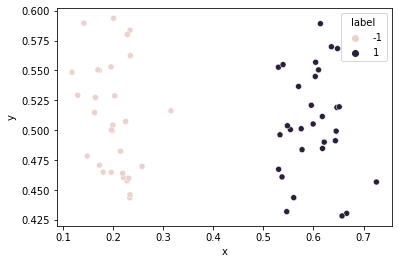

In [ ]:
import seaborn as sns
sns.scatterplot(data=df, x='x', y='y', hue='label')

**Метод логистической регрессии**

Метод является линейным и байессовским классификатором.

Суть заключается в использовании логистической функции потерь $L(M) = log_2 (1 + e^{-M})$.

Правило обновления весов: $w = w + \eta x_i y_i \sigma(-<w, x_i> y_i)$, где $\sigma(z) = \frac{1}{1 + e^{-z}}$ - это сигмоидная функция.

Метод помимо классификации позволяет вычислить апостериорную вероятность принадлежности объекта классу: $P(y|x) = \sigma(<w,x> y)$.


In [ ]:
"""
Реализация сигмоидной функции
"""
def sigma(z):
  return 1 / (1 + np.exp(-z))

"""
Класс реализует метод логичтической регрессии.
Наследует класс LinearBinaryClassifier и передаются нужные функция потерь
и правило обновления весов.
"""
class LogisticRegression(LinearBinaryClassifier):
  def stochastic_gradient(self, lmbda, learning_rate):
    def loss_function(f, y):
      m = f * y
      return np.log2(1 + np.exp(-m))

    def update_rule(w, f, y, x, learning_rate):
      return w + learning_rate * x * y * sigma(-f * y)

    return super(LogisticRegression, self).stochastic_gradient(loss_function, update_rule, lmbda, learning_rate)

  """
  Метод возвращающий вероятность принадлжености предсказанному классу
  """
  def get_probability(self, obj):
    y = self.predict(obj)[0]
    obj = np.append(obj, 1)
    return sigma(np.dot(self.w, obj) * y)

  """
  Метод рисует карту классификации. Раскрашивает более темным цветом объекты
  с более высокой вероятностью. Цвета заданы как (X, 0, 0) и (0, 0, X) в RGB,
  где Х считается на основе вероятности.
  """
  def draw_classification_map(self):
    plt.axis([0, 1, 0, 1])
    step = 0.01

    minv, maxv = 1, 0
    for i in np.arange(0, 1 + step, step):
      for j in np.arange(0, 1 + step, step):
        p = self.get_probability(np.array([i, j]))
        minv = min(minv, p)
        maxv = max(maxv, p)
    
    for i in np.arange(0, 1 + step, step):
      for j in np.arange(0, 1 + step, step):
        p = self.get_probability(np.array([i, j]))
        label = self.predict(np.array([i, j]))[0]
        percent = 1 - (p - minv) / (maxv - minv)
        color = (percent, 0, 0) if label == 1 else (0, 0, percent)
        plt.scatter(i, j, color=color)

Визуализация обучения логистической регрессии методом стохастического градиента:

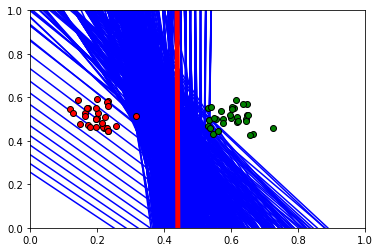

In [ ]:
LR = LogisticRegression(X, y)
LR.stochastic_gradient(0.01, 0.01)
LR.visualize_training()

Карта классификации, чем темнее цвет, тем выше вероятность принадлежности классу:

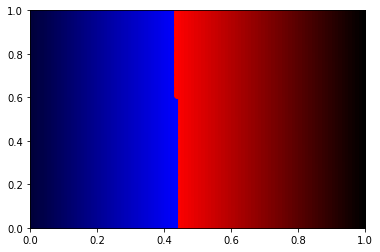

In [ ]:
LR.draw_classification_map()

Преимущества метода: 
- использует более плавную функцию потерь, что дает более качественные результаты.
- дает возможность оценки вероятности принадлежности объекта классу.

Недостатки метода: 
- если нарушены требования теоремы, то оценки вероятностей окажутся неадекватными
- унаследованы все недостатки стохастического градиентного спуска

